
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [53]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV


In [54]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [55]:
ha['cp'] = ha['cp'].astype('category')
ha['sex'] = ha['sex'].astype('category')
ha['restecg'] = ha['restecg'].astype('category')

In [56]:
X = ha[["age","chol"]]
y = ha["cp"]
ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
         make_column_selector(dtype_include=['category', 'object']))
    ],
    remainder="passthrough"
)

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


**Multiclass KNN**

In [57]:
import numpy as np
knn_pipeline = Pipeline(
    [("preprocessing", ct),
     ("knn", KNeighborsClassifier())]
)

k_values = [74, 75, 76]
k_param = {'knn__n_neighbors': k_values}
gscv = GridSearchCV(knn_pipeline, k_param, cv=5, scoring='accuracy')

gscv_fitted = gscv.fit(X, y)
accuracy_scores = gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data={"k values": k_values, "Acc scores": accuracy_scores})

best_accuracy = np.max(gscv_fitted.cv_results_['mean_test_score'])
best_k_value = gscv_fitted.best_params_['knn__n_neighbors']
print("Best Accuracy Score:", best_accuracy)
print("Corresponding K-Value:", best_k_value)

Best Accuracy Score: 0.4761616161616161
Corresponding K-Value: 75


In [58]:
from sklearn.model_selection import cross_val_score
knn_pipeline = Pipeline(
    [("preprocessing", ct),
     ("knn", KNeighborsClassifier(n_neighbors=75))]
)

knn_pipeline_fitted = knn_pipeline.fit(X,y)
knn_accuracy = cross_val_score(knn_pipeline_fitted, X, y, cv=5, scoring='accuracy').mean()
print(f"KNN Accuracy: {knn_accuracy}")

KNN Accuracy: 0.4761616161616161


**Multiclass Decision Tree**

In [59]:
dt_pipeline = Pipeline([
    ("preprocessing", ct),
    ("decision_tree", DecisionTreeClassifier())
])

leaf_values = [65,66,67,68,69]
leaf_param = {
    'decision_tree__min_samples_leaf': leaf_values}

gscv = GridSearchCV(dt_pipeline, leaf_param, cv=5, scoring='accuracy')
gscv.fit(X, y)
acc_scores = gscv.cv_results_['mean_test_score']

best_accuracy = np.max(gscv.cv_results_['mean_test_score'])
best_min_samples_leaf = gscv.best_params_['decision_tree__min_samples_leaf']
print("Best Accuracy Score:", best_accuracy)
print("Corresponding min_samples_leaf:", best_min_samples_leaf)

Best Accuracy Score: 0.4760942760942761
Corresponding min_samples_leaf: 66


In [60]:
dt_pipeline = Pipeline([
    ("preprocessing", ct),
    ("decision_tree", DecisionTreeClassifier(min_samples_leaf=66))
])

dt_pipeline_fitted = dt_pipeline.fit(X,y)
dt_accuracy = cross_val_score(dt_pipeline_fitted, X, y, cv=5, scoring='accuracy').mean()
print(f"DT Accuracy: {dt_accuracy}")

DT Accuracy: 0.4760942760942761


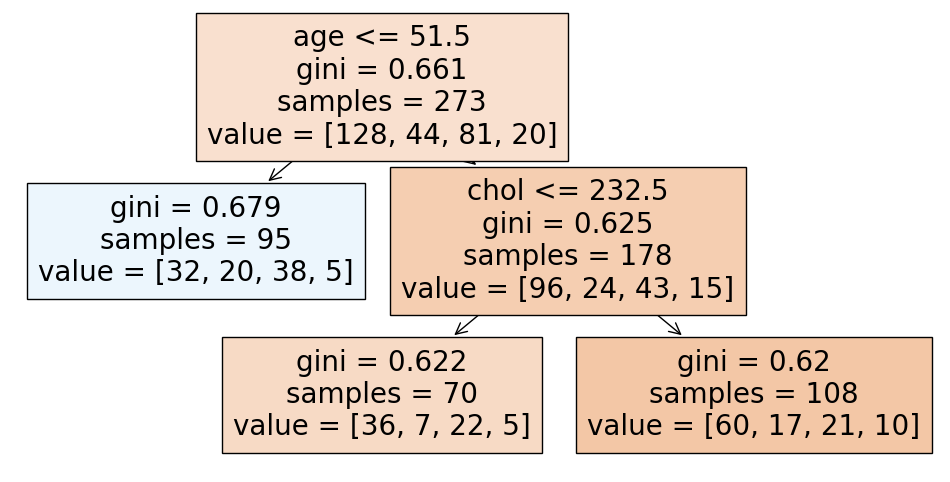

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plot_tree(dt_pipeline_fitted.named_steps["decision_tree"], filled=True, feature_names=["age", "chol"])
plt.show()

The top node is the root node.  The Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. The value array likely represents the counts of samples in each class or category that the tree is trying to predict. The condition here is checking if the feature age is less than or equal to 51.5. If true, we move to the left child node; if false, we move to the right child node.

**Multiclass LDA**

In [62]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_pipeline = Pipeline([
    ("preprocessing", ct),
    ("LDA", LinearDiscriminantAnalysis())
])
lda_model = lda_pipeline.fit(X,y)
lda_accuracy = cross_val_score(lda_model, X, y, cv=5, scoring='accuracy').mean()
print(f"LDA Accuracy: {lda_accuracy}")

LDA Accuracy: 0.4468013468013468


## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [63]:
silly = pd.get_dummies(ha['cp'], prefix = "cp_is")
ha = ha.join(silly)

In [64]:
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output,cp_is_0,cp_is_1,cp_is_2,cp_is_3
0,63,1,3,145,233,0,150,1,0,0,0,1
1,37,1,2,130,250,1,187,1,0,0,1,0
2,56,1,1,120,236,1,178,1,0,1,0,0
3,57,0,0,120,354,1,163,1,1,0,0,0
4,57,1,0,140,192,1,148,1,1,0,0,0


In [75]:
X = ha[["age", "chol"]]
y = ha["cp_is_0"]

lr_pipeline = Pipeline([
    ("preprocessing", ct),
    ("logistic_regression", LogisticRegression())
])

lr_pipeline_fitted0 = lr_pipeline.fit(X,y)

lr_f1_0 = cross_val_score(lr_pipeline_fitted0, X, y, cv=5, scoring='f1_macro').mean()
print(f"cp = 0 Logistic Regression F1 Score: {lr_f1_0}")

cp = 0 Logistic Regression F1 Score: 0.5486327137775371


In [79]:
X = ha[["age", "chol"]]
y = ha["cp_is_1"]

lr_pipeline_fitted1 = lr_pipeline.fit(X,y)

lr_f1_1 = cross_val_score(lr_pipeline_fitted1, X, y, cv=5, scoring='f1_macro').mean()
print(f"cp = 1 Logistic Regression F1 Score: {lr_f1_1}")

cp = 1 Logistic Regression F1 Score: 0.45617641764176414


In [80]:
X = ha[["age", "chol"]]
y = ha["cp_is_2"]

lr_pipeline_fitted2 = lr_pipeline.fit(X,y)

lr_f1_2 = cross_val_score(lr_pipeline_fitted2, X, y, cv=5, scoring='f1_macro').mean()
print(f"cp = 2 Logistic Regression F1 Score: {lr_f1_2}")

cp = 2 Logistic Regression F1 Score: 0.41289526822038536


In [83]:
X = ha[["age", "chol"]]
y = ha["cp_is_3"]

lr_pipeline_fitted3 = lr_pipeline.fit(X,y)

lr_f1_3 = cross_val_score(lr_pipeline_fitted3, X, y, cv=5, scoring='f1_macro').mean()
print(f"cp = 3 Logistic Regression F1 Score: {lr_f1_3}")

cp = 3 Logistic Regression F1 Score: 0.48098693759071115


cp = 0 was the category the OvR was best at distinguishing.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [87]:
ha_reduced = ha[ha['cp'].isin([0,1])]
X = ha_reduced[["age","chol"]]
y = ha_reduced["cp"]

lr_pipeline01 = lr_pipeline.fit(X, y)

zero1_ROC = cross_val_score(lr_pipeline01, X, y, cv=5, scoring='roc_auc').mean()
print(f"Zero-one ROC AUC: {zero1_ROC}")

Zero-one ROC AUC: 0.6096410256410256


In [89]:
ha_reduced2 = ha[ha['cp'].isin([0,2])]
X = ha_reduced2[["age","chol"]]
y = ha_reduced2["cp"]

lr_pipeline02 = lr_pipeline.fit(X, y)

zero2_ROC = cross_val_score(lr_pipeline02, X, y, cv=5, scoring='roc_auc').mean()
print(f"Zero-two ROC AUC: {zero2_ROC}")

Zero-two ROC AUC: 0.5822319004524886


In [90]:
ha_reduced3 = ha[ha['cp'].isin([0,3])]
X = ha_reduced3[["age","chol"]]
y = ha_reduced3["cp"]

lr_pipeline03 = lr_pipeline.fit(X, y)

zero3_ROC = cross_val_score(lr_pipeline03, X, y, cv=5, scoring='roc_auc').mean()
print(f"Zero-three ROC AUC: {zero3_ROC}")

Zero-three ROC AUC: 0.37907692307692303


The pair that the OvO approach was best at distinguishing was zero-one.